In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os.path
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from statsmodels.discrete.discrete_model import Logit
import attila_utils
import gem_tools

In [2]:
ar_mssm = gem_tools.read_active_reactions(groupdict={'m-control': ('all_control', 'MSBB'), 'm-AD-B2': ('SubtypeB2_AD', 'MSBB')})
data_mssm = gem_tools.long_ar_subsys(['Bile acid recycling'], ar_mssm, gem_tools.read_gem_excel()['SUBSYSTEM'])
data_mssm

rxn_state disease_state    rxn_ID  \
ID                                                               
MAR01847 S151B648.BM_36_428          1     m-control  MAR01847   
         S151B648.BM_36_429          1     m-control  MAR01847   
         S111B355.BM_36_412          1     m-control  MAR01847   
         S111B355.BM_36_416          1     m-control  MAR01847   
         S111B355.BM_36_414          1     m-control  MAR01847   
...                                ...           ...       ...   
MAR01896 S151B648.BM_36_496          0       m-AD-B2  MAR01896   
         P19B648.BM_36_543           0       m-AD-B2  MAR01896   
         S151B648.BM_36_505          0       m-AD-B2  MAR01896   
         S111B355.BM_36_387          0       m-AD-B2  MAR01896   
         P19B648.BM_36_544           0       m-AD-B2  MAR01896   

                                     subject_ID  
ID                                               
MAR01847 S151B648.BM_36_428  S151B648.BM_36_428  
         S151B648.BM_36_429  S151B648.BM_36_429  
         S111B355.BM_36_412  S111B355.BM_36_412  
         S111B355.BM_36_416  S111B355.BM_36_416  
         S111B355.BM_36_414  S111B355.BM_36_414  
...                                         ...  
MAR01896 S151B648.BM_36_496  S151B648.BM_36_496  
         P19B648.BM_36_543    P19B648.BM_36_543  
         S151B648.BM_36_505  S151B648.BM_36_505  
         S111B355.BM_36_387  S111B355.BM_36_387  
         P19B648.BM_36_544    P19B648.BM_36_544  

[2046 rows x 4 columns]

In [3]:
gem_1_11 = gem_tools.read_gem_excel()

In [4]:
fpath = '../../resources/tunahan/Dilara-APOE-models/APOE_BinaryModels.xlsx'
dilara_data = pd.read_excel(fpath)

In [5]:
def excise_group(group, dilara_data):
    left = dilara_data.loc[:, ['Rxn_ID']].rename({'Rxn_ID': 'rxn_ID'}, axis=1)
    right = dilara_data.loc[:, [bool(re.match('^' + group + '.*$', c)) for c in dilara_data.columns]]
    res = pd.concat([left, right], axis=1)
    res = res.set_index('rxn_ID').astype('bool')
    return(res)

ar = dict()

for celltype in ['Neuron', 'Astrocyte', 'Microglia']:
    for isoform in ['e3', 'e4']:
        group = celltype + '_' + isoform
        fpath = '../../resources/tunahan/Dilara-APOE-models/' + group + '.xlsx'
        ar[group] = excise_group(group, dilara_data)
        ar[group].to_excel(fpath, index=False)

ar['Astrocyte_e3']

,Astrocyte_e3_1,Astrocyte_e3_2,Astrocyte_e3_3
rxn_ID,,,
MAR00001,False,False,False
MAR00002,False,False,False
MAR00003,True,True,False
MAR00004,True,True,True
MAR00005,True,True,True
...,...,...,...
MAR13079,False,False,False
MAR13080,False,False,False
MAR13081,False,False,True


In [6]:
gem = dilara_data.loc[:, ['Rxn_ID', 'Subsystem']].rename({'Rxn_ID': 'ID', 'Subsystem': 'SUBSYSTEM'}, axis=1).set_index('ID')['SUBSYSTEM']
gem

ID
MAR00001          Acylglycerides metabolism
MAR00002          Acylglycerides metabolism
MAR00003          Acylglycerides metabolism
MAR00004                Transport reactions
MAR00005          Acylglycerides metabolism
                         ...               
MAR13079                Transport reactions
MAR13080                Transport reactions
MAR13081          Oxidative phosphorylation
MAR13082               Artificial reactions
MAR13083    Metabolism of other amino acids
Name: SUBSYSTEM, Length: 13078, dtype: object

In [7]:
def prepare_data(subsystems, ar, gem):
    data = gem_tools.long_ar_subsys(subsystems, ar, gem)
    data['cell_type'] = data.disease_state.apply(lambda x: re.sub('^([^_]+)_(e[34])$', '\\1', x))    
    data['APOE_isoform'] = data.disease_state.apply(lambda x: re.sub('^([^_]+)_(e[34])$', '\\2', x))
    return(data)

In [8]:
subsystems = ['Bile acid biosynthesis']
data_b = prepare_data(subsystems, ar, gem)
data_b

rxn_state disease_state    rxn_ID      subject_ID  \
ID                                                                           
MAR00059 Neuron_e3_1             0     Neuron_e3  MAR00059     Neuron_e3_1   
         Neuron_e3_2             0     Neuron_e3  MAR00059     Neuron_e3_2   
         Neuron_e3_3             0     Neuron_e3  MAR00059     Neuron_e3_3   
MAR00069 Neuron_e3_1             0     Neuron_e3  MAR00069     Neuron_e3_1   
         Neuron_e3_2             0     Neuron_e3  MAR00069     Neuron_e3_2   
...                            ...           ...       ...             ...   
MAR12299 Microglia_e4_2          0  Microglia_e4  MAR12299  Microglia_e4_2   
         Microglia_e4_3          0  Microglia_e4  MAR12299  Microglia_e4_3   
MAR12305 Microglia_e4_1          0  Microglia_e4  MAR12305  Microglia_e4_1   
         Microglia_e4_2          0  Microglia_e4  MAR12305  Microglia_e4_2   
         Microglia_e4_3          0  Microglia_e4  MAR12305  Microglia_e4_3   

                         cell_type APOE_isoform  
ID                                               
MAR00059 Neuron_e3_1        Neuron           e3  
         Neuron_e3_2        Neuron           e3  
         Neuron_e3_3        Neuron           e3  
MAR00069 Neuron_e3_1        Neuron           e3  
         Neuron_e3_2        Neuron           e3  
...                            ...          ...  
MAR12299 Microglia_e4_2  Microglia           e4  
         Microglia_e4_3  Microglia           e4  
MAR12305 Microglia_e4_1  Microglia           e4  
         Microglia_e4_2  Microglia           e4  
         Microglia_e4_3  Microglia           e4  

[4734 rows x 6 columns]

In [9]:
subsystems = ['Bile acid recycling']
data_r = prepare_data(subsystems, ar, gem)
data_r

rxn_state disease_state    rxn_ID      subject_ID  \
ID                                                                           
MAR01847 Neuron_e3_1             1     Neuron_e3  MAR01847     Neuron_e3_1   
         Neuron_e3_2             1     Neuron_e3  MAR01847     Neuron_e3_2   
         Neuron_e3_3             1     Neuron_e3  MAR01847     Neuron_e3_3   
MAR01848 Neuron_e3_1             0     Neuron_e3  MAR01848     Neuron_e3_1   
         Neuron_e3_2             1     Neuron_e3  MAR01848     Neuron_e3_2   
...                            ...           ...       ...             ...   
MAR01894 Microglia_e4_2          0  Microglia_e4  MAR01894  Microglia_e4_2   
         Microglia_e4_3          0  Microglia_e4  MAR01894  Microglia_e4_3   
MAR01896 Microglia_e4_1          1  Microglia_e4  MAR01896  Microglia_e4_1   
         Microglia_e4_2          1  Microglia_e4  MAR01896  Microglia_e4_2   
         Microglia_e4_3          1  Microglia_e4  MAR01896  Microglia_e4_3   

                         cell_type APOE_isoform  
ID                                               
MAR01847 Neuron_e3_1        Neuron           e3  
         Neuron_e3_2        Neuron           e3  
         Neuron_e3_3        Neuron           e3  
MAR01848 Neuron_e3_1        Neuron           e3  
         Neuron_e3_2        Neuron           e3  
...                            ...          ...  
MAR01894 Microglia_e4_2  Microglia           e4  
         Microglia_e4_3  Microglia           e4  
MAR01896 Microglia_e4_1  Microglia           e4  
         Microglia_e4_2  Microglia           e4  
         Microglia_e4_3  Microglia           e4  

[594 rows x 6 columns]

In [10]:
def fit_mixed(data=data_b):
    formula = 'rxn_state ~ C(APOE_isoform, levels=["e3", "e4"]) : C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])'
    fit_method = 'fit_vb'
    md = BinomialBayesMixedGLM.from_formula(formula, {'Reactions': 'rxn_ID'}, data=data, vcp_p=0.2, fe_p=2)#.fit()
    fit = getattr(md, fit_method)
    res_mixed = fit()
    return(res_mixed)

res_mixed_b, res_mixed_r = [fit_mixed(data) for data in [data_b, data_r]]
res_mixed_b.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-1.2438,0.0566,,,
"C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[T.Astrocyte]",M,0.5143,0.1016,,,
"C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[T.Microglia]",M,3.5700,0.0844,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Neuron]",M,-0.1471,0.1653,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Astrocyte]",M,0.2684,0.1406,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Microglia]",M,-0.2304,0.1190,,,
Reactions,V,1.2198,0.0404,3.387,3.124,3.672


In [11]:
res_mixed_r.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-1.7850,0.1719,,,
"C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[T.Astrocyte]",M,2.0753,0.2710,,,
"C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[T.Microglia]",M,2.0647,0.2750,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Neuron]",M,-0.6693,0.5498,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Astrocyte]",M,0.3398,0.3728,,,
"C(APOE_isoform, levels=[""e3"", ""e4""])[T.e4]:C(cell_type, levels=[""Neuron"", ""Astrocyte"", ""Microglia""])[Microglia]",M,0.0621,0.3833,,,
Reactions,V,0.7423,0.0883,2.101,1.761,2.507


In [12]:
def fit_fixed(data=data_b):
    formula = 'rxn_state ~ C(APOE_isoform, levels=["e3", "e4"]) : C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])'
    res_fixed = Logit.from_formula(formula, data=data).fit()
    return(res_fixed)

res_fixed_b, res_fixed_r = [fit_fixed(data) for data in [data_b, data_r]]
res_fixed_b.summary()

Optimization terminated successfully.
         Current function value: 0.475341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382472
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              rxn_state   No. Observations:                 4734
Model:                          Logit   Df Residuals:                     4728
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                 0.07707
Time:                        14:11:12   Log-Likelihood:                -2250.3
converged:                       True   LL-Null:                       -2438.2
Covariance Type:            nonrobust   LLR p-value:                 4.814e-79
===================================================================================================================================================================================
                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          -2.0752      0.113    -18.349      0.000      -2.297      -1.854
C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Astrocyte]                                              0.2656      0.153      1.741      0.082      -0.033       0.565
C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Microglia]                                              1.6080      0.135     11.939      0.000       1.344       1.872
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Neuron]       -0.0522      0.162     -0.323      0.747      -0.369       0.265
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Astrocyte]     0.1301      0.142      0.919      0.358      -0.147       0.408
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Microglia]    -0.0920      0.104     -0.884      0.377      -0.296       0.112
===================================================================================================================================================================================
"""

In [13]:
res_fixed_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              rxn_state   No. Observations:                  594
Model:                          Logit   Df Residuals:                      588
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                 0.05440
Time:                        14:11:12   Log-Likelihood:                -227.19
converged:                       True   LL-Null:                       -240.26
Covariance Type:            nonrobust   LLR p-value:                 8.389e-05
===================================================================================================================================================================================
                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          -2.9339      0.459     -6.392      0.000      -3.833      -2.034
C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Astrocyte]                                              1.4298      0.528      2.709      0.007       0.395       2.464
C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Microglia]                                              1.4298      0.528      2.709      0.007       0.395       2.464
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Neuron]       -0.2337      0.686     -0.341      0.733      -1.579       1.112
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Astrocyte]     0.1304      0.361      0.361      0.718      -0.578       0.839
C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Microglia]  1.014e-15      0.369   2.75e-15      1.000      -0.722       0.722
===================================================================================================================================================================================
"""

## Presentation

In [14]:
res_mixed_b.model.exog_names

['Intercept',
 'C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Astrocyte]',
 'C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[T.Microglia]',
 'C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Neuron]',
 'C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Astrocyte]',
 'C(APOE_isoform, levels=["e3", "e4"])[T.e4]:C(cell_type, levels=["Neuron", "Astrocyte", "Microglia"])[Microglia]']

In [15]:
exog_new_names = ['Intercept', 'Astrocyte vs Neuron', 'Microglia vs Neuron', 'e4 vs e3 | Neuron', 'e4 vs e3 | Astrocyte', 'e4 vs e3 | Microglia']
exog_old2new_names = dict(zip(res_mixed_b.model.exog_names, exog_new_names))

In [16]:
def get_summary_mixed(res_mixed=res_mixed_b):
    d = {'mean': res_mixed.fe_mean, 'bse': res_mixed.fe_sd, 'pval': np.nan, 'treatment': exog_new_names, 'model': 'logistic mixed'}
    summary_mixed = pd.DataFrame(d, index=exog_new_names)
    return(summary_mixed)

summary_mixed_b, summary_mixed_r = [get_summary_mixed(res_mixed) for res_mixed in [res_mixed_b, res_mixed_r]]
summary_mixed_b

,mean,bse,pval,treatment,model
Intercept,-1.243830,0.056627,NaN,Intercept,logistic mixed
Astrocyte vs Neuron,0.514283,0.101621,NaN,Astrocyte vs Neuron,logistic mixed
Microglia vs Neuron,3.569976,0.084378,NaN,Microglia vs Neuron,logistic mixed
e4 vs e3 | Neuron,-0.147118,0.165269,NaN,e4 vs e3 | Neuron,logistic mixed
e4 vs e3 | Astrocyte,0.268389,0.140576,NaN,e4 vs e3 | Astrocyte,logistic mixed
e4 vs e3 | Microglia,-0.230400,0.118980,NaN,e4 vs e3 | Microglia,logistic mixed


In [17]:
def fresults2df(res_fixed, exog_old2new_names=exog_old2new_names):
    def results2df(res_fixed):
        df = pd.concat([res_fixed.params.to_frame('mean'),
                        res_fixed.bse.to_frame('bse'),
                        res_fixed.pvalues.to_frame('pval')], axis=1)
        df['treatment'] = df.index
        return(df)
    summary_fixed = results2df(res_fixed).rename(exog_old2new_names, axis=0)
    summary_fixed['treatment'] = exog_new_names
    summary_fixed['model'] = 'logistic fixed'
    return(summary_fixed)

summary_fixed_b, summary_fixed_r = [fresults2df(res) for res in [res_fixed_b, res_fixed_r]]
summary = pd.concat([summary_fixed_b, summary_mixed_b], axis=0)
summary

,mean,bse,pval,treatment,model
Intercept,-2.075171,0.113094,3.353698e-75,Intercept,logistic fixed
Astrocyte vs Neuron,0.265554,0.152559,8.174152e-02,Astrocyte vs Neuron,logistic fixed
Microglia vs Neuron,1.608050,0.134690,7.423192e-33,Microglia vs Neuron,logistic fixed
e4 vs e3 | Neuron,-0.052210,0.161596,7.466281e-01,e4 vs e3 | Neuron,logistic fixed
e4 vs e3 | Astrocyte,0.130112,0.141606,3.581848e-01,e4 vs e3 | Astrocyte,logistic fixed
e4 vs e3 | Microglia,-0.091997,0.104056,3.766387e-01,e4 vs e3 | Microglia,logistic fixed
Intercept,-1.243830,0.056627,NaN,Intercept,logistic mixed
Astrocyte vs Neuron,0.514283,0.101621,NaN,Astrocyte vs Neuron,logistic mixed
Microglia vs Neuron,3.569976,0.084378,NaN,Microglia vs Neuron,logistic mixed
e4 vs e3 | Neuron,-0.147118,0.165269,NaN,e4 vs e3 | Neuron,logistic mixed


/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

(1e-76, 1)

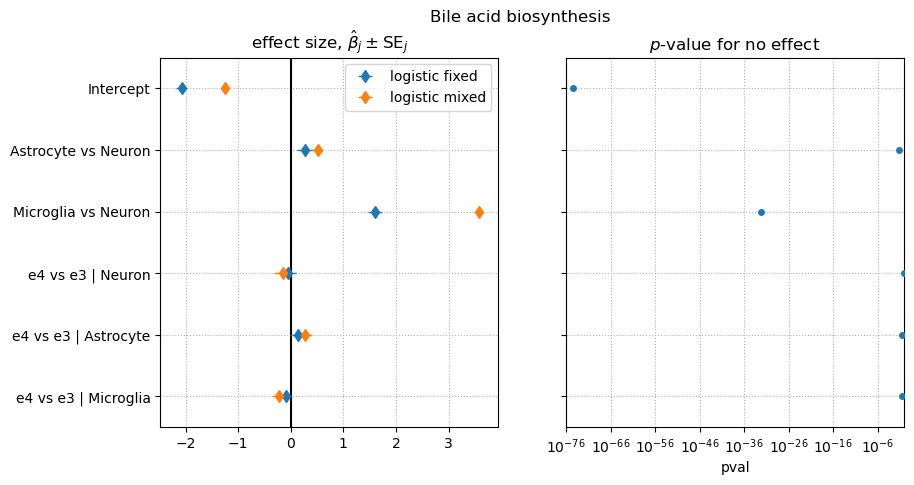

In [18]:
def my_plotter(summary_fixed, summary_mixed, suptitle='Bile acid biosynthesis'):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    ax[0].axvline(0, color='k')
    for df, model_type in zip([summary_fixed, summary_mixed], ['logistic fixed', 'logistic mixed']):
        ax[0].errorbar(y=np.arange(df.shape[0]), x=df['mean'], xerr=df['bse'], linewidth=0, elinewidth=1, marker='d', capsize=0, label=model_type)
    ax[0].legend()
    ax[0].set_yticks(np.arange(df.shape[0]))
    ax[0].set_yticklabels(df.index)
    ax[0].grid(linestyle='dotted')
    ax[0].set_title(r'effect size, $\hat{\beta}_j \pm \mathrm{SE}_j$')
    sns.stripplot(x='pval', y='treatment', ax=ax[1], data=summary_fixed)
    ax[1].set_xscale('log')
    ax[1].grid(linestyle='dotted')
    ax[1].set_title(r'$p$-value for no effect')
    fig.suptitle(suptitle)
    return((fig, ax))

fig, ax = my_plotter(summary_fixed_b, summary_mixed_b)
ax[1].set_xlim([1e-76, 1])

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

(1e-10, 1)

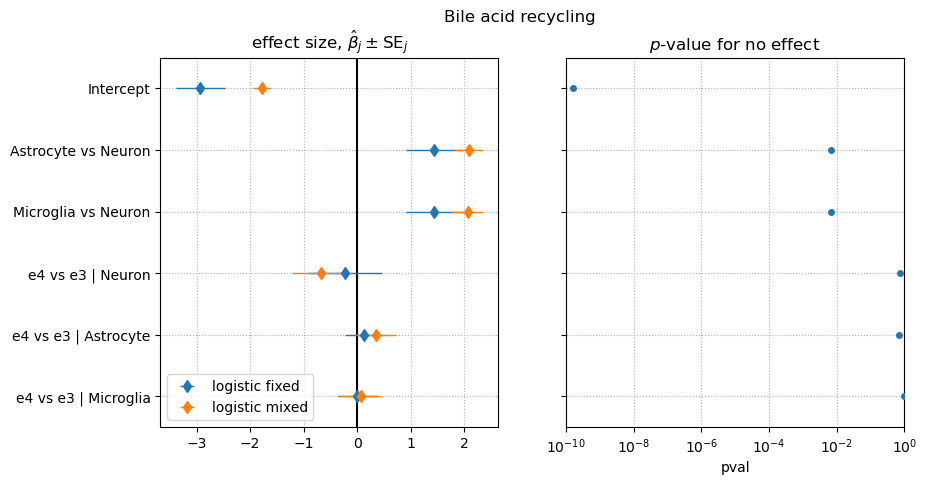

In [19]:
fig, ax = my_plotter(summary_fixed_r, summary_mixed_r, suptitle='Bile acid recycling')
ax[1].set_xlim([1e-10, 1])

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

(0.01, 1)

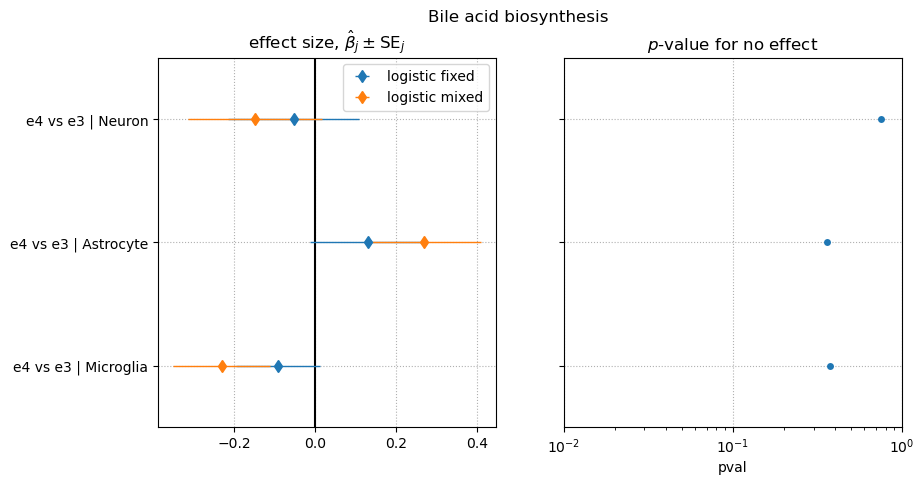

In [20]:
l = [df.drop(['Intercept', 'Astrocyte vs Neuron', 'Microglia vs Neuron']) for df in [summary_fixed_b, summary_mixed_b]]
fig, ax = my_plotter(*l)
ax[1].set_xlim([1e-2, 1])

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

(0.01, 1)

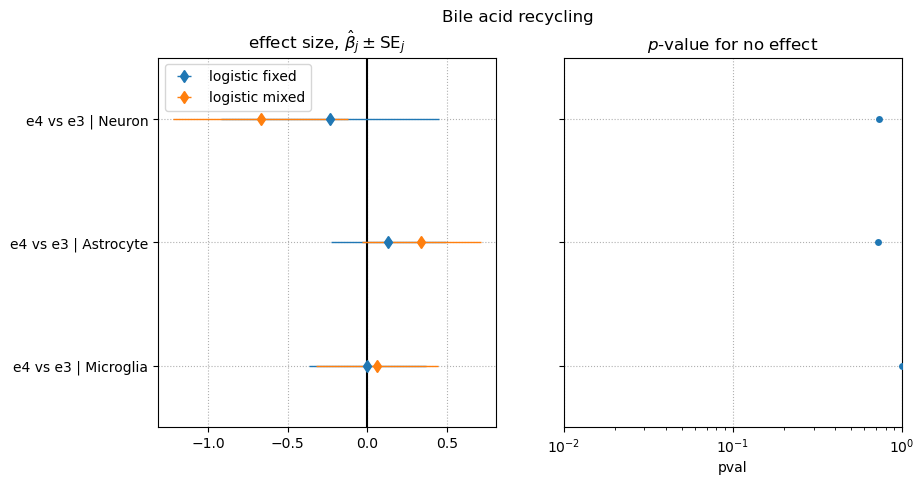

In [21]:
l = [df.drop(['Intercept', 'Astrocyte vs Neuron', 'Microglia vs Neuron']) for df in [summary_fixed_r, summary_mixed_r]]
fig, ax = my_plotter(*l, suptitle='Bile acid recycling')
ax[1].set_xlim([1e-2, 1])

In [22]:
%connect_info

{
  "shell_port": 65148,
  "iopub_port": 65149,
  "stdin_port": 65150,
  "control_port": 65152,
  "hb_port": 65151,
  "ip": "127.0.0.1",
  "key": "337d9f31-248a8bfdc81c28ed56250ea2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-06590383-4ece-4222-82eb-1ff4ca13e81d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
